<a href="https://colab.research.google.com/github/Sang565/Parking-prediction-using-LSTM-based-model/blob/main/Parking_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking prediction using Deep LSTM-based model

Running parking occupancy prediction with the real **Birmingham parking dataset**

Dataset link: https://archive.ics.uci.edu/ml/datasets/Parking+Birmingham#



# Import libraries

In [32]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
                                                            
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator  #must use this one for training with TimeSeriesGenerator 
import tensorflow as tf 

# Part 1. Data Pre-processing

# Read dataset

Read dataset and convert to pandas dataFrame

In [33]:
#df = pd.read_csv('/content/dataset.csv')   # via the file downloaded
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00482/dataset.zip')  # directly from the dataset website

In [34]:
df  # dataset exploration

,SystemCodeNumber,Capacity,Occupancy,LastUpdated
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48
...,...,...,...,...
35712,Shopping,1920,1517,2016-12-19 14:30:33
35713,Shopping,1920,1487,2016-12-19 15:03:34
35714,Shopping,1920,1432,2016-12-19 15:29:33
35715,Shopping,1920,1321,2016-12-19 16:03:35


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717 entries, 0 to 35716
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SystemCodeNumber  35717 non-null  object
 1   Capacity          35717 non-null  int64 
 2   Occupancy         35717 non-null  int64 
 3   LastUpdated       35717 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [36]:
df.shape

(35717, 4)

Dataset info:
- Collected 8:00-16:30 from 11/01/2016 to 17/05/2016 (11 weeks - 77 days)

- 30 different carpark (CP)

- Update time inverval is 10 minutes

- Total no. of records: 19,735 

- 18 records/day/carpark --> total no. of records of each CP: around 1,386


**Some attribute information: **

SystemCodeNumber: carpark ID

Capacity: CP capacity

Occupancy: CP occupancy

LastUpdated: record update time


In [37]:
df.LastUpdated.head()

0    2016-10-04 07:59:42
1    2016-10-04 08:25:42
2    2016-10-04 08:59:42
3    2016-10-04 09:32:46
4    2016-10-04 09:59:48
Name: LastUpdated, dtype: object

Convert date format from object type to datetime64 type to apply training and prediction

In [38]:
#add column 'date' by converting column 'LastUpdated' into datetime64 format
df['date'] = pd.to_datetime(df['LastUpdated'], infer_datetime_format=True) 

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717 entries, 0 to 35716
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SystemCodeNumber  35717 non-null  object        
 1   Capacity          35717 non-null  int64         
 2   Occupancy         35717 non-null  int64         
 3   LastUpdated       35717 non-null  object        
 4   date              35717 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.4+ MB


In [40]:
df.date

0       2016-10-04 07:59:42
1       2016-10-04 08:25:42
2       2016-10-04 08:59:42
3       2016-10-04 09:32:46
4       2016-10-04 09:59:48
                ...        
35712   2016-12-19 14:30:33
35713   2016-12-19 15:03:34
35714   2016-12-19 15:29:33
35715   2016-12-19 16:03:35
35716   2016-12-19 16:30:35
Name: date, Length: 35717, dtype: datetime64[ns]

In [41]:
df.date.head()

0   2016-10-04 07:59:42
1   2016-10-04 08:25:42
2   2016-10-04 08:59:42
3   2016-10-04 09:32:46
4   2016-10-04 09:59:48
Name: date, dtype: datetime64[ns]

**------------ Select a specific CP to do prediction ----------**


In [42]:
# 28 working CPs: 
#    BHMBCCMKT01, BHMBCCPST01, BHMBCCSNH01, BHMBCCTHL01, BHMBRCBRG01, BHMBRCBRG02, BHMBRCBRG03, BHMEURBRD01, BHMEURBRD02, BHMMBMMBX01,
#    BHMNCPHST01, BHMNCPLDH01, BHMNCPNHS01, BHMNCPNST01, BHMNCPPLS01, BHMNCPRAN01, Broad Street, Bull Ring, NIA Car Parks, NIA South, 
#    Others-CCCPS105a, Others-CCCPS119a, Others-CCCPS133, Others-CCCPS135a, Others-CCCPS202, Others-CCCPS8, Others-CCCPS98, Shopping
#
# 2 fault CPs: BHMBRTARC01 (88 records), NIA North (126 records)  --> Not running!!!

# Select the target CP 
df_cp_filtered = df[df['SystemCodeNumber'].str.match('BHMBCCMKT01')]

df_cp_filtered

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,date
0,BHMBCCMKT01,577,61,2016-10-04 07:59:42,2016-10-04 07:59:42
1,BHMBCCMKT01,577,64,2016-10-04 08:25:42,2016-10-04 08:25:42
2,BHMBCCMKT01,577,80,2016-10-04 08:59:42,2016-10-04 08:59:42
3,BHMBCCMKT01,577,107,2016-10-04 09:32:46,2016-10-04 09:32:46
4,BHMBCCMKT01,577,150,2016-10-04 09:59:48,2016-10-04 09:59:48
...,...,...,...,...,...
1307,BHMBCCMKT01,577,309,2016-12-19 14:30:33,2016-12-19 14:30:33
1308,BHMBCCMKT01,577,300,2016-12-19 15:03:34,2016-12-19 15:03:34
1309,BHMBCCMKT01,577,274,2016-12-19 15:29:33,2016-12-19 15:29:33
1310,BHMBCCMKT01,577,230,2016-12-19 16:03:35,2016-12-19 16:03:35


In [43]:
# df_cp_filtered

In [44]:
df_cp_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1312 entries, 0 to 1311
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SystemCodeNumber  1312 non-null   object        
 1   Capacity          1312 non-null   int64         
 2   Occupancy         1312 non-null   int64         
 3   LastUpdated       1312 non-null   object        
 4   date              1312 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 61.5+ KB


Set index column and select features

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f71d0495a90>],
      dtype=object)

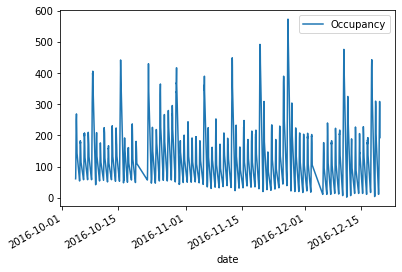

In [45]:
# Set index (use date column) and select features and do plotting for viewing
df_cp_filtered.set_index('date') [['Occupancy']].plot(subplots=True)  # 2 steps: select column works as index,  and plot selected column (not the index column)


In [46]:
# Select final input feature ('Occupany')
df_input = df_cp_filtered[['Occupancy']]  # df_input also use 'date' for index, inherited from df
df_input.head()

,Occupancy
0,61
1,64
2,80
3,107
4,150


In [47]:
df_input.shape

(1312, 1)

In [48]:
# check the distribution of input features
df_input.describe()

,Occupancy
count,1312.000000
mean,162.029726
std,99.404980
min,2.000000
25%,91.000000
50%,157.000000
75%,206.000000
max,573.000000


In [49]:
# other testing
#df_input.query('Occupancy > 1200')  

# Data sclaling to [0, 1] range

In [50]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [51]:
data_scaled

array([[0.1033275 ],
       [0.10858144],
       [0.13660245],
       ...,
       [0.47635727],
       [0.39929947],
       [0.33450088]])

In [52]:
data_scaled.shape

(1312, 1)

# Features (Inputs) and Target (Output prediction) selections 

In [53]:
# Feature selection and Target predicted selection 
features = data_scaled  # use for input 

target = data_scaled[:,0] # use for output prediction

In [54]:
target

array([0.1033275 , 0.10858144, 0.13660245, ..., 0.47635727, 0.39929947,
       0.33450088])

In [55]:
target.shape  # (19735,) --> one column by default

(1312,)

# Generate x_train/x_test, y_train/y_test 

- Have to generate **y_train/y_test** (for time series prediction) based on sliding windows of input data (x_train) 
  
  For example, taking every group of 126 records (or 1-week data) to work as x_train to create one sigle future record (y_train) since y_train does not exist in the dataset.

In [56]:
# create x_train, x_test, y_train, and y_test
# 80% for training, 20% for testing and evaluation
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False) # remember to set shuffle=False --> important for TS prediction

In [57]:
x_train.shape # 80%

(1049, 1)

In [58]:
x_test.shape

(263, 1)

Create **a data structure** with 126 timestamps of inputs (1 week data of each CP) --> to create 1 output

In [59]:
# Create a data structure with 126 timestamps of inputs --> to create 1 output
# using TimeSeriesGenerator() function
window_length=126
batch_size=32

train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [60]:
train_generator[0]  # 32 groups (batch_size) of an array of 126 arrays of x_train, and and an array of 32 values of y_train
                    # Or 126 [0:125] input records (rows) --> create one output record (i.e. the value of record 127)

(array([[[0.1033275 ],
         [0.10858144],
         [0.13660245],
         ...,
         [0.22241681],
         [0.22416813],
         [0.19614711]],
 
        [[0.10858144],
         [0.13660245],
         [0.18388792],
         ...,
         [0.22416813],
         [0.19614711],
         [0.09457093]],
 
        [[0.13660245],
         [0.18388792],
         [0.2591944 ],
         ...,
         [0.19614711],
         [0.09457093],
         [0.10858144]],
 
        ...,
 
        [[0.30998249],
         [0.30122592],
         [0.2732049 ],
         ...,
         [0.2469352 ],
         [0.2732049 ],
         [0.27145359]],
 
        [[0.30122592],
         [0.2732049 ],
         [0.25043783],
         ...,
         [0.2732049 ],
         [0.27145359],
         [0.28371278]],
 
        [[0.2732049 ],
         [0.25043783],
         [0.22241681],
         ...,
         [0.27145359],
         [0.28371278],
         [0.28896673]]]),
 array([0.09457093, 0.10858144, 0.12609457, 0.15936953,

In [61]:
# checking 
x_train[126]  # -->  equal to the first value in train_generator[0] array

array([0.09457093])

# Part 2. Create a model (LSTM-based) 

In [62]:
# Initializing the Neural Network 
model = tf.keras.Sequential()

# Adding 1st LSTM layer
model.add(tf.keras.layers.LSTM(128, input_shape=(window_length, 1), return_sequences=True))

# Adding 2nd LSTM layer
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2)) 

# Adding 3rd LSTM layer
model.add(tf.keras.layers.LSTM(32, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2)) 

# Output layer
model.add(tf.keras.layers.Dense(1))

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 126, 128)          66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 126, 64)           49408     
_________________________________________________________________
dropout (Dropout)            (None, 126, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 128,417
Trainable params: 128,417
Non-trainable params: 0
________________________________________________

# Part 3. Train the model

Using TensorBoard (optional)

In [64]:
tb = tf.keras.callbacks.TensorBoard(log_dir='logs',histogram_freq=1) 

Configure: Checking and monitoring

In [65]:
#---- Configure: checking and monitoring ---------------------
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min') # 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=50, mode='min') # USing

#---- Save model option ------------------------
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True) # not USE
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='mean_absolute_error', verbose=1, save_best_only=True, save_weights_only=True)  # USing


Compile and Train the model

In [66]:
#----- Compiling the Neural Network
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),   # use Adam optimizer
              metrics=[tf.metrics.MeanAbsoluteError()])   

# Start training   
history = model.fit( 
                    train_generator, 
                    epochs=1000,  
                    validation_data=test_generator, # for model validation 
                    shuffle=False,
                    verbose=1,                    
                    #callbacks=[early_stopping, model_checkpoint, tb]  # for model saving and Tensorboard
                    callbacks=[early_stopping, tb]     # for Tensorboard
                    #callbacks=[early_stopping]  # for faster running without model saving and tb     
                    )

Epoch 1/1000
29/29 [==============================] - 2s 67ms/step - loss: 0.0382 - mean_absolute_error: 0.1520 - val_loss: 0.0326 - val_mean_absolute_error: 0.1402
Epoch 2/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0333 - mean_absolute_error: 0.1378 - val_loss: 0.0315 - val_mean_absolute_error: 0.1363
Epoch 3/1000
29/29 [==============================] - 1s 26ms/step - loss: 0.0294 - mean_absolute_error: 0.1289 - val_loss: 0.0272 - val_mean_absolute_error: 0.1241
Epoch 4/1000
29/29 [==============================] - 1s 26ms/step - loss: 0.0223 - mean_absolute_error: 0.1092 - val_loss: 0.0191 - val_mean_absolute_error: 0.1076
Epoch 5/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0149 - mean_absolute_error: 0.0908 - val_loss: 0.0119 - val_mean_absolute_error: 0.0862
Epoch 6/1000
29/29 [==============================] - 1s 25ms/step - loss: 0.0122 - mean_absolute_error: 0.0832 - val_loss: 0.0100 - val_mean_absolute_error: 0.0735
Epoch 7/10

Invoke Tensorboard

In [67]:
# Load the TensorBoard notebook extension 
# https://stackoverflow.com/questions/55970686/tensorboard-not-found-as-magic-function-in-jupyter

%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

# Part 4. Model evaluation

In [69]:
model.evaluate(test_generator, verbose=1)   # better to use different test_generator and validate_generator data for model evaluate and validation purposes
                                            #    in this case, we are using the same test_generator data
                                            # results: val_loss, val_MAE

5/5 [==============================] - 0s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0230


[0.001104577793739736, 0.02304689772427082]

# Part 5. Model inference (Prediction )

Do Prediction

In [70]:
predictions = model.predict(test_generator)   

In [71]:
#predictions
predictions[0:9]

array([[0.09752665],
       [0.18224058],
       [0.30175054],
       [0.31971985],
       [0.3017431 ],
       [0.31196183],
       [0.32925165],
       [0.32939136],
       [0.30301443]], dtype=float32)

In [72]:
predictions.shape # (137, 1)  --> y_test.shape = (263,) since 263-126 = 137

(137, 1)

In [73]:
y_test.shape

(263,)

# Part 6. Present the prediction results using graph

Inverse Transform

In [74]:
df_pred_rev = scaler.inverse_transform(predictions)

Append columns into the current DataFrame for better presentation

In [75]:
df_input.shape

(1312, 1)

In [76]:
df_final = df_input[predictions.shape[0]*-1:] 

In [77]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 1175 to 1311
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Occupancy  137 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


In [78]:
# change column name from 'Occupancy' to 'Occ_Actual'
df_final.columns = ['Occ_Actual']

In [79]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137 entries, 1175 to 1311
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Occ_Actual  137 non-null    int64
dtypes: int64(1)
memory usage: 2.1 KB


append one more column (named 'Occ_Predicted') into the final dataFrame 


In [80]:
df_final['Occ_Predicted'] = df_pred_rev[:,0] # append one more column (named 'Occ_Predicted') into df_final 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
df_final.head()

,Occ_Actual,Occ_Predicted
1175,99,57.687721
1176,142,106.059364
1177,157,174.299561
1178,157,184.560043
1179,167,174.295303


Plotting

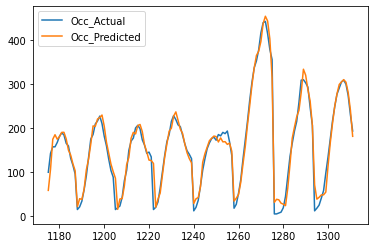

In [82]:
df_final[['Occ_Actual','Occ_Predicted']].plot()